# **Micro Analysis, Macro Outcomes: Boosting BigMart Sales with Predictive Analytics**

by

**VISWADHANUSH B R**

**GURUPRASATH B**

**ASHFAQ SULTAN M**

**Importing Libraries**

In [48]:
#Essential Libraries
import pandas as pd
import numpy as np

#Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from plotly import graph_objs as go
import plotly.express as px

#Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# For Bokeh in Colab
output_notebook()

#Warnings
import warnings
warnings.filterwarnings('ignore')

The code imports several libraries for data analysis and visualization. **Pandas** and **NumPy** are used for data manipulation and numerical computations. **Seaborn** and **Matplotlib** provide tools for static visualizations, while **Bokeh** and **Plotly** enable interactive plots. For machine learning, **Scikit-learn** offers algorithms like Decision Trees and Random Forests, while **XGBoost** is used for boosting models. The libraries collectively facilitate efficient data handling, comprehensive visual analysis, and robust predictive modeling for informed decision-making.

**Loading Dataset**

In [49]:
train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')

The datasets were successfully loaded using pandas with the `read_csv` function. The training data is stored in the variable `train`, while the test data is in `test`. This setup allows for subsequent analysis and model training on the training set, followed by evaluation on the test set.

**Data Preprocessing**

In [54]:
#Checking Null Values for Train Dataset
train.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


In [55]:
#Checking Null Values for Test Dataset
test.isnull().sum()

,0
Item_Identifier,0
Item_Weight,976
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,1606
Outlet_Location_Type,0


In [59]:
data = pd.concat([train_data, test_data], ignore_index=True)
data['Item_Weight'].fillna(data['Item_Weight'].mean(), inplace=True)

if 'Outlet_Size' in data.columns:
    data['Outlet_Size'].fillna(data['Outlet_Size'].mode()[0], inplace=True)

In [61]:
#Performing one-hot encoding after handling missing values
data = pd.get_dummies(data, drop_first=True)

In [62]:
train_data = data[:len(train_data)]
test_data = data[len(train_data):]

In [63]:
X = train_data.drop(columns=['Item_Outlet_Sales'])
y = train_data['Item_Outlet_Sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

The code performs essential data preprocessing steps on the training and test datasets. It checks for null values, finding and addressing them by filling missing entries in the `Item_Weight` column with the mean and in the `Outlet_Size` column with the mode. Next, one-hot encoding is applied to convert categorical variables into a numerical format, enhancing model compatibility. The processed data is split back into training and test sets, with the features stored in `X` and the target variable `y`. Finally, the training data is divided into training and validation sets using an 80-20 split for model evaluation.

**Exploratory Data Analysis**

In [92]:
#Sales Distribution Plot
hist, edges = np.histogram(train_data['Item_Outlet_Sales'], bins=50)
p = figure(title="Distribution of Item Outlet Sales", background_fill_color="#fafafa")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color="darkblue", line_color="black", alpha=0.7)
show(p)

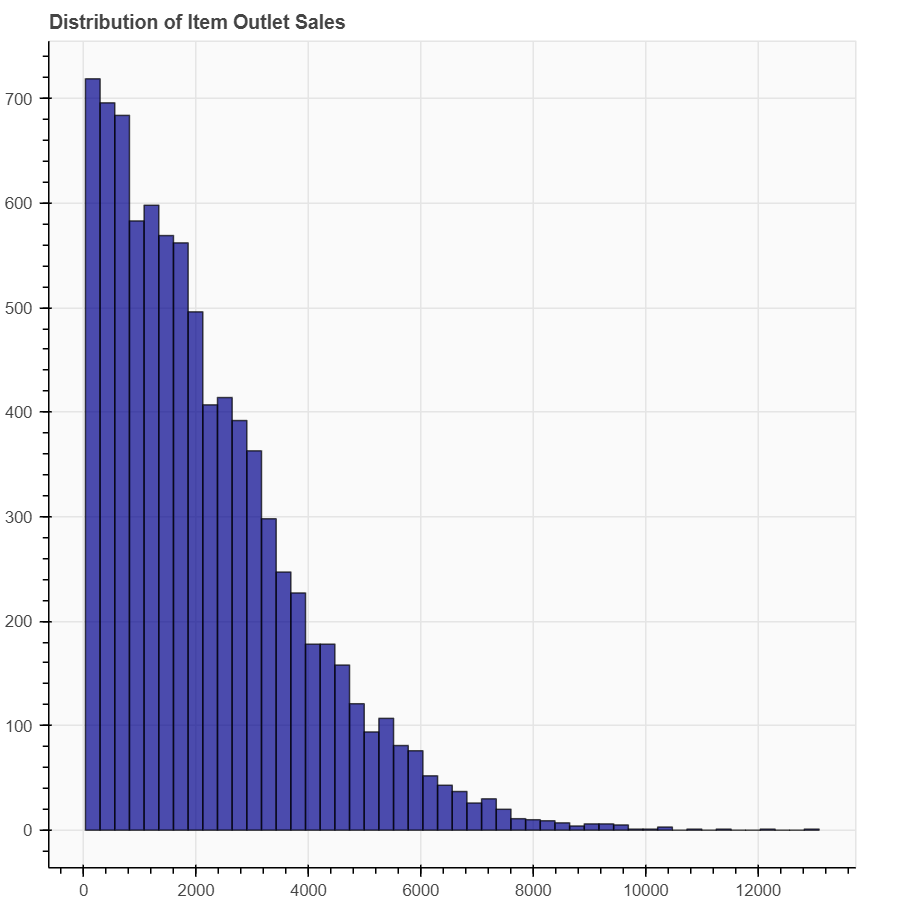

This histogram shows the distribution of item outlet sales with a right-skewed distribution, meaning most sales are on the lower end, and fewer items have high sales values. The peak on the left side represents the majority of items sold in lower quantities, while the long tail to the right indicates a smaller number of items with significantly higher sales.

In [67]:
#Sales by Outlet Type
fig = px.box(train_data, x='Outlet_Type_Supermarket Type1', y='Item_Outlet_Sales',
             title="Sales by Outlet Type", labels={'x':'Outlet Type', 'y':'Item Outlet Sales'})
fig.show()

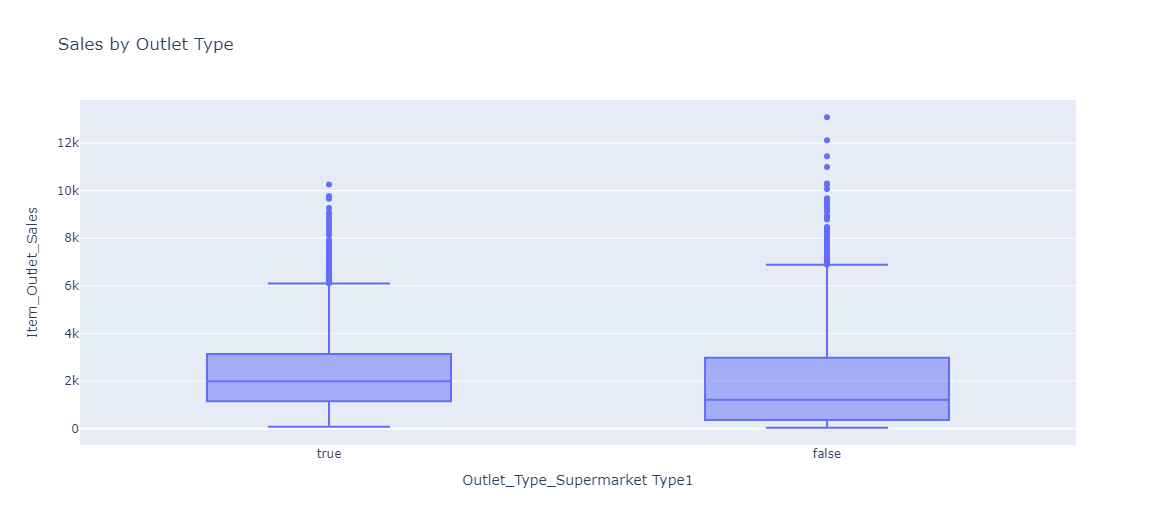

This box plot shows the distribution of item outlet sales based on whether the outlet type is **"Supermarket Type1"** (true) or not (false). Both categories have a similar median sales level, but **"Supermarket Type1"** outlets exhibit a slightly wider range of sales values, indicating more variability. Additionally, both types have several high outliers, with sales reaching up to 12,000, although the majority of sales are concentrated below 5,000.

**Predictive Modeling**

In [79]:
# Dictionary to store performance metrics for comparison
performance_metrics = {'Model': [], 'RMSE': [], 'R2 Score': []}

In [80]:
#Evaluating model performance
def evaluate_model(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, R2 Score: {r2:.2f}")
    performance_metrics['Model'].append(model_name)
    performance_metrics['RMSE'].append(rmse)
    performance_metrics['R2 Score'].append(r2)
    return rmse, r2

The function **evaluate_model** assesses model performance by predicting validation data and calculating RMSE and R² scores. It stores these metrics in a dictionary for further analysis, aiding model comparison.

In [81]:
#Generating Actual vs. Predicted plot
def plot_actual_vs_predicted(y_val, y_pred, model_name):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_val, y=y_pred, mode='markers',
                             name="Predictions vs Actuals", marker=dict(color="blue", opacity=0.6)))
    fig.add_trace(go.Scatter(x=[y_val.min(), y_val.max()], y=[y_val.min(), y_val.max()],
                             mode='lines', name="Perfect Fit", line=dict(color="red")))
    fig.update_layout(title=f"{model_name} - Predictions vs Actuals",
                      xaxis_title="Actual Item Outlet Sales",
                      yaxis_title="Predicted Item Outlet Sales",
                      showlegend=True)
    fig.show()

The **plot_actual_vs_predicted** function creates a scatter plot comparing actual versus predicted values for a given model. It uses blue markers to represent predictions and includes a red line indicating a perfect fit. The plot effectively visualizes model accuracy, helping identify discrepancies between predicted and actual sales.

In [82]:
#Decision Tree Regression
print("Decision Tree:")
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
evaluate_model(dt_model, X_val, y_val, "Decision Tree")

Decision Tree:
Decision Tree - RMSE: 1466.97, R2 Score: 0.21


(1466.9703849130024, 0.20823185779578002)

In [83]:
# Decision Tree - Predictions vs Actuals
y_pred_dt = dt_model.predict(X_val)
plot_actual_vs_predicted(y_val, y_pred_dt, "Decision Tree")

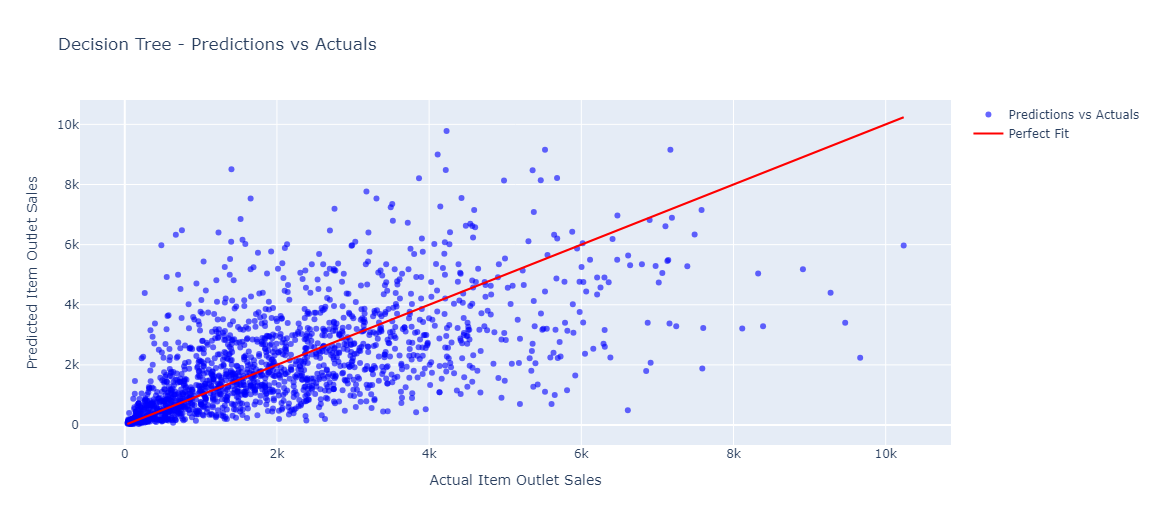

This scatter plot compares the actual versus predicted item outlet sales from a decision tree model. The red line represents a perfect fit, where predictions equal actual values. Most points are close to the line for lower sales, indicating reasonable accuracy in that range. However, as sales increase, predictions become more scattered, suggesting that the model struggles with high sales values, likely due to overfitting or limitations in handling extreme values.

In [84]:
#Random Forest Regression
print("\nRandom Forest:")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_val, y_val, "Random Forest")


Random Forest:
Random Forest - RMSE: 1095.97, R2 Score: 0.56


(1095.9671579084288, 0.5580731274538868)

In [85]:
# Random Forest - Predictions vs Actuals
y_pred_rf = rf_model.predict(X_val)
plot_actual_vs_predicted(y_val, y_pred_rf, "Random Forest")

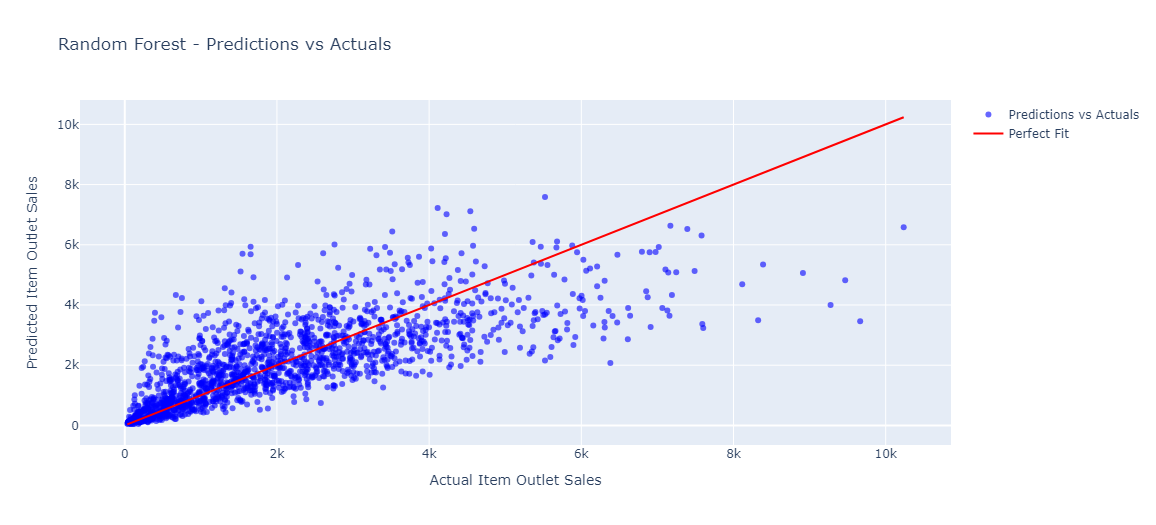

The scatter plot shows the Random Forest model's predictions against actual values for item outlet sales. The majority of points are closely aligned along the red "Perfect Fit" line, indicating good model performance. However, there is a spread at higher sales values, suggesting that the model may underpredict for higher sales. This dispersion highlights potential model limitations at extreme values, though it performs reasonably well overall in predicting sales within the observed range.

In [86]:
#XGBoost
print("\nXGBoost:")
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_val, y_val, "XGBoost")


XGBoost:
XGBoost - RMSE: 1050.92, R2 Score: 0.59


(1050.9187199062724, 0.5936562475744216)

In [87]:
# XGBoost - Predictions vs Actuals
y_pred_xgb = xgb_model.predict(X_val)
plot_actual_vs_predicted(y_val, y_pred_xgb, "XGBoost")

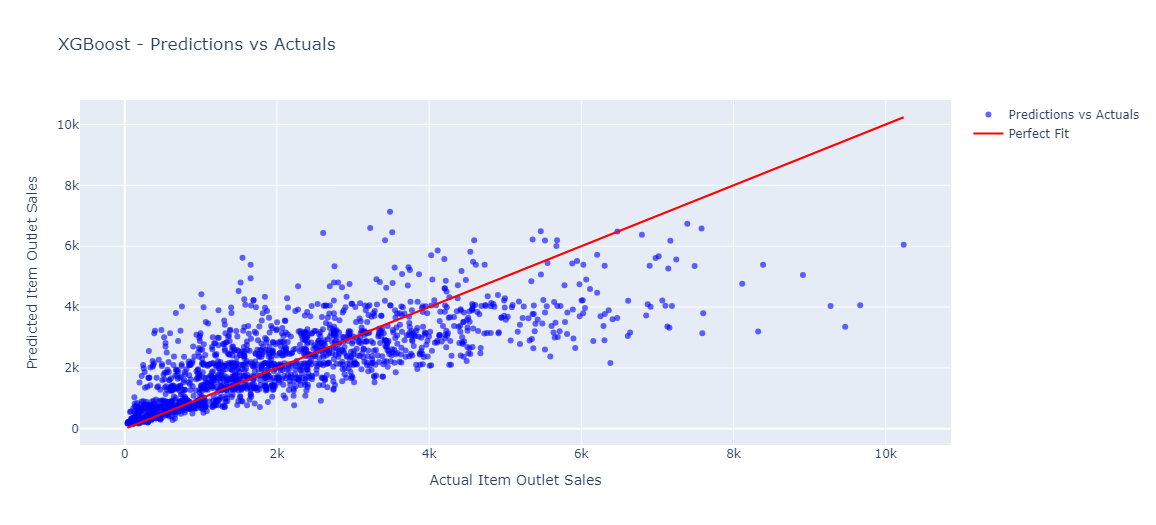

The scatter plot compares XGBoost model predictions to actual item outlet sales values. Most points lie close to the red "Perfect Fit" line, showing that the model predicts well for many observations. However, it tends to underpredict higher sales, similar to the Random Forest model, as seen by the spread of points above the line at larger values. This suggests that while XGBoost captures general trends, it struggles with high-value predictions, indicating potential areas for model improvement.

**Model Comparison and Visualization**

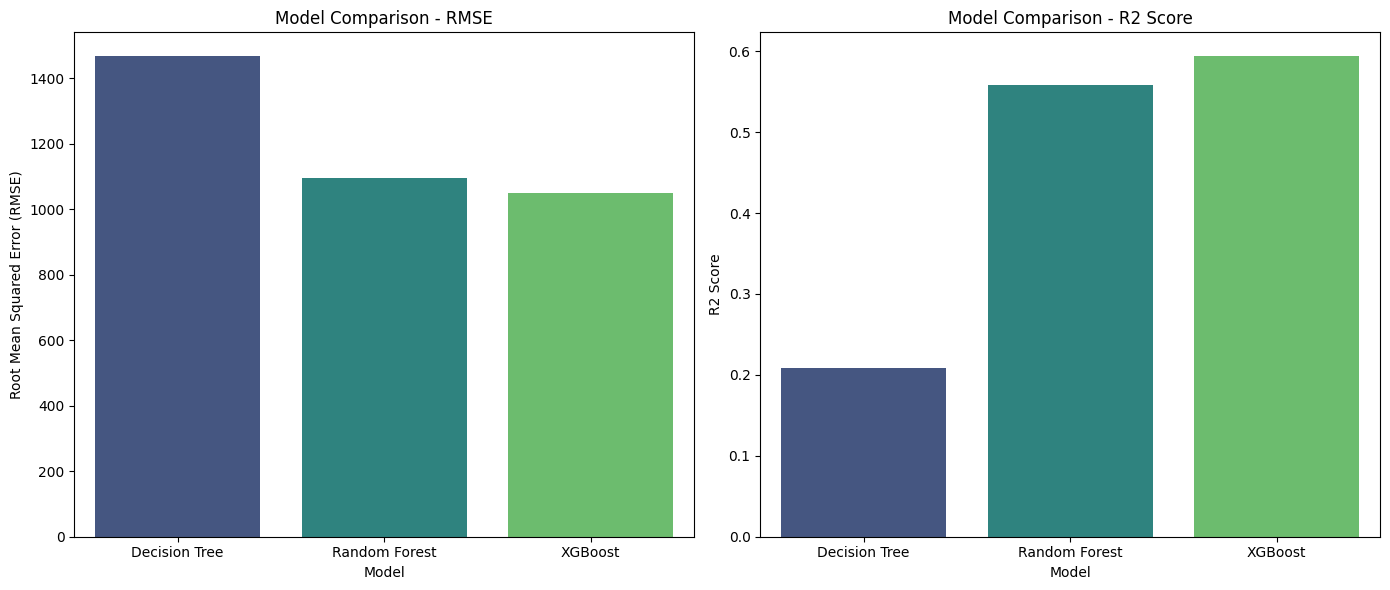

In [88]:
performance_df = pd.DataFrame(performance_metrics)

# Plotting RMSE and R2 Score comparison
plt.figure(figsize=(14, 6))

# RMSE comparison
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE', data=performance_df, palette='viridis')
plt.title("Model Comparison - RMSE")
plt.xlabel("Model")
plt.ylabel("Root Mean Squared Error (RMSE)")

# R2 Score comparison
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R2 Score', data=performance_df, palette='viridis')
plt.title("Model Comparison - R2 Score")
plt.xlabel("Model")
plt.ylabel("R2 Score")

plt.tight_layout()
plt.show()

**Conclusion**

In [89]:
best_model = performance_df.loc[performance_df['RMSE'].idxmin()]
print("\nConclusion:")
print("Performance summary:")
print(performance_df)
print(f"\nBest model based on RMSE: {best_model['Model']} with RMSE: {best_model['RMSE']:.2f} and R2 Score: {best_model['R2 Score']:.2f}")


Conclusion:
Performance summary:
           Model         RMSE  R2 Score
0  Decision Tree  1466.970385  0.208232
1  Random Forest  1095.967158  0.558073
2        XGBoost  1050.918720  0.593656

Best model based on RMSE: XGBoost with RMSE: 1050.92 and R2 Score: 0.59


In our analysis of BigMart sales, we evaluated three predictive models: Decision Tree Regression, Random Forest Regression, and XGBoost. The performance summary indicated that **XGBoost** emerged as the best model, achieving the lowest **RMSE of 1050.92** and the highest **R² score of 0.59**. This suggests that XGBoost effectively captures the variability in sales data compared to the other models. Utilizing this model can enhance decision-making and strategic planning, ultimately boosting BigMart's sales performance through informed insights.